A notebook which will contain plots showing data summaries for every year combined.

In [1]:
import sys
sys.path.append('/ocean/kflanaga/MEOPAR/analysis-keegan/notebooks/Tools')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
import json
import f90nml
import Keegan_eval_tools as ket
from collections import OrderedDict
from matplotlib.colors import LogNorm

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [3]:
years=range(2007,2020)
modelversion='nowcast-green.201905'
PATH= '/results2/SalishSea/nowcast-green.201905/'
datadir='/ocean/eolson/MEOPAR/obs/WADE/ptools_data/ecology'

In [4]:
display(Markdown('''## All years Summary ## '''))

## All years Summary ## 

In [5]:
display(Markdown('''### Model output: '''+ PATH))

### Model output: /results2/SalishSea/nowcast-green.201905/

## Yearly model-data comparisons of nutrients, chlorophyll, temperature and salinity between 201905 runs and WADE observations

In [6]:
##### Loading in pickle file data
dictbot=dict()
saveloc='/ocean/kflanaga/MEOPAR/savedData'

for Y in years:
    with open(os.path.join(saveloc,f'data_WADE_{modelversion}_{Y}.pkl'),'rb') as hh:
        dictbot[Y]=pickle.load(hh)
    
data=pd.concat(dictbot.values(), ignore_index=True)

In [7]:
#There are a couple of observed ammonium values that are absurdly high above the average value.
#These next bits of code are meant to erase those values. 
for e,i in enumerate(data.Amm):
    if i > 15:
        data.Amm.replace(i,float("NaN"),inplace=True)
        
for e,i in enumerate(data.Amm[data.Basin == 'Hood Canal Basin']):
    if i > 9:
        data.Amm.replace(i,float("NaN"),inplace=True)

# dictionaries that contain relevant subsets ofthe data.
datstat=dict()
for ind, istation in enumerate(data.Station.unique()):
    datstat[istation]=data.loc[data.Station == istation]
    
datreg=dict()
for iregion in data.Basin.unique():
    datreg[iregion] = data.loc[data.Basin==iregion]  

In [8]:
# Creating seperate dataframes for each season (includes only data above 15 metre depth.)
iz=(data.Z<15)
JFMd=dict()
Aprd=dict()
MJJAd=dict()
SONDd=dict()
for i in years:
    JFMd[i]=data.loc[iz&(data.dtUTC>=dt.datetime(i,1,1))&(data.dtUTC<=dt.datetime(i,4,1)),:]
    Aprd[i]=data.loc[iz&(data.dtUTC<=dt.datetime(i,5,1))&(data.dtUTC>dt.datetime(i,4,1)),:]
    MJJAd[i]=data.loc[iz&(data.dtUTC<=dt.datetime(i,9,1))&(data.dtUTC>dt.datetime(i,5,1)),:]
    SONDd[i]=data.loc[iz&(data.dtUTC>dt.datetime(i,9,1))&(data.dtUTC<=dt.datetime(i,12,31)),:]
JFM=pd.concat(JFMd.values(), ignore_index=True)
Apr=pd.concat(Aprd.values(), ignore_index=True)
MJJA=pd.concat(MJJAd.values(), ignore_index=True)
SOND=pd.concat(SONDd.values(), ignore_index=True)

In [9]:
### These groupings will be used to calculate statistics. The keys are labels and
### the values are corresponding dataframe views
statsubs=OrderedDict({'z < 15 m':data.loc[data.Z<15],
                      '15 m < z < 22 m':data.loc[(data.Z>=15)&(data.Z<22)],
                      'z >= 22 m':data.loc[data.Z>=22],
                      'z > 50 m':data.loc[data.Z>50],
                      'all':data,
                      'z < 15 m, JFM':JFM,
                      'z < 15 m, Apr':Apr,
                      'z < 15 m, MJJA':MJJA,
                      'z < 15 m, SOND': SOND,})
for iregion in data.Basin.unique():
    statsubs[iregion]=datreg[iregion]
statsubs.keys()

odict_keys(['z < 15 m', '15 m < z < 22 m', 'z >= 22 m', 'z > 50 m', 'all', 'z < 15 m, JFM', 'z < 15 m, Apr', 'z < 15 m, MJJA', 'z < 15 m, SOND', 'Main Basin', 'Hood Canal Basin', 'Admiralty Inlet', 'Strait of Georgia', 'Whidbey Basin', 'South Basin', 'Strait of Juan de Fuca'])

## Map of observation locations in each basin

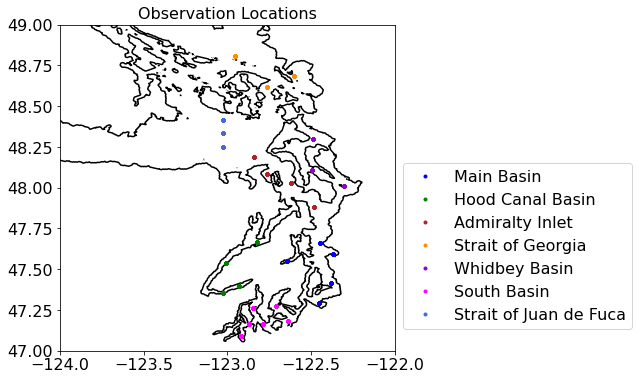

In [10]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('blue','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue')
for ind, iregion in enumerate(data.Basin.unique()):
    ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47, 49)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-124, -122);
ax.set_title('Observation Locations');

# Nitrate

### Table containing evaluation statistics for relevant subsets

In [11]:
# Defining variables needed for nitrate evaluations
obsvar='NO23'
modvar='mod_nitrate'
seasons=[JFM,Apr,MJJA,SOND]

In [12]:
statsDict=dict()
statsDict['NO3']=OrderedDict()
for isub in statsubs:
    print(isub)
    statsDict['NO3'][isub]=dict()
    var=statsDict['NO3'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict['NO3'],level='Subset',suborder=list(statsubs.keys()))
tbl

z < 15 m
15 m < z < 22 m
z >= 22 m
z > 50 m
all
z < 15 m, JFM
z < 15 m, Apr
z < 15 m, MJJA
z < 15 m, SOND
Main Basin
Hood Canal Basin
Admiralty Inlet
Strait of Georgia
Whidbey Basin
South Basin
Strait of Juan de Fuca


### Model vs Observed comparisons by depth and region

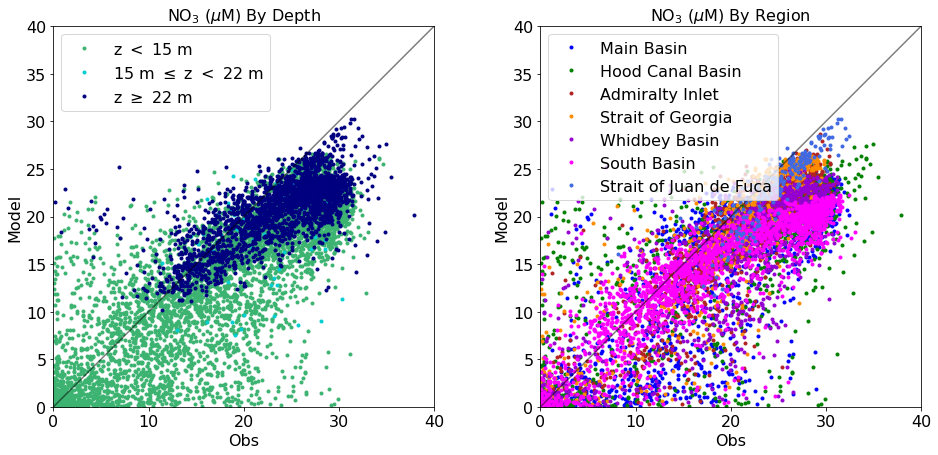

In [13]:
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data,obsvar,modvar,(0,40))
ax[0].set_title('NO$_3$ ($\mu$M) By Depth')

ps,l=ket.byRegion(ax[1],data,datreg,obsvar,modvar,(0,40))
ax[1].set_title('NO$_3$ ($\mu$M) By Region');

## 2D histogram of modeled vs observed data

Text(0.5, 1.0, 'NO$_3$ ($\\mu$M)')

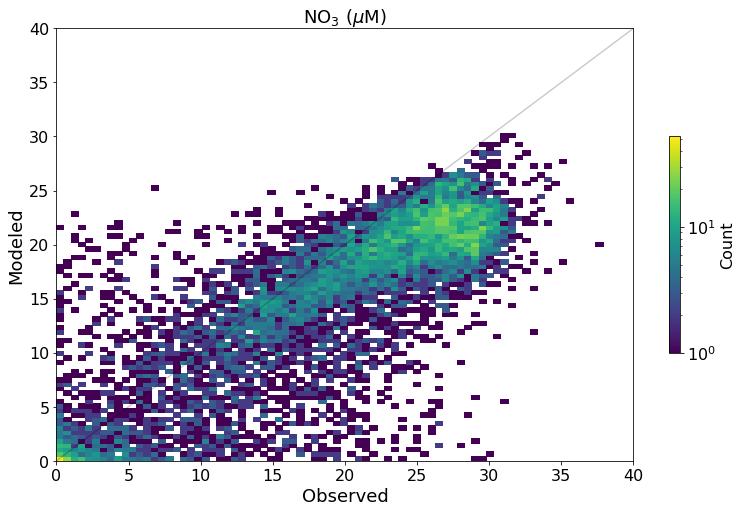

In [14]:
fig, ax = plt.subplots(1,1,figsize= (11,7))
ps = ket.hist2d(ax,fig,data,obsvar,modvar,(0,40),fontsize=18)
ax.set_title('NO$_3$ ($\mu$M)',fontsize=18)

### Model vs Observed comparisons for individual seasons

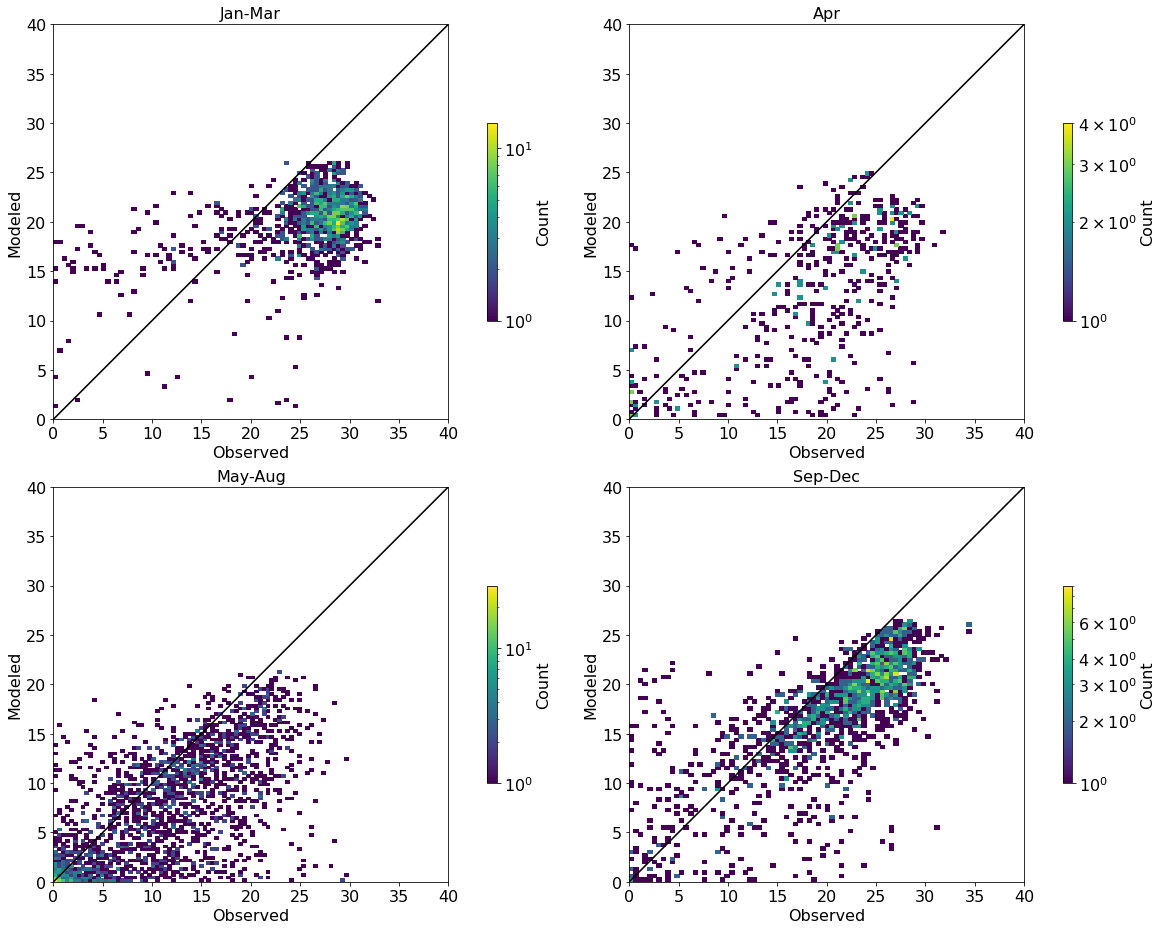

In [15]:
fig, ax = plt.subplots(2,2,figsize = (19,13))
ket.bySeason_hist2d(ax,fig,seasons,obsvar,modvar,(0,40))
for i in range(2):
    for j in range(2):
        ax[i][j].set_ylabel('Modeled',fontsize=16)
        ax[i][j].set_xlabel('Observed',fontsize=16)   

### Model vs Observed comparisons for individual regions

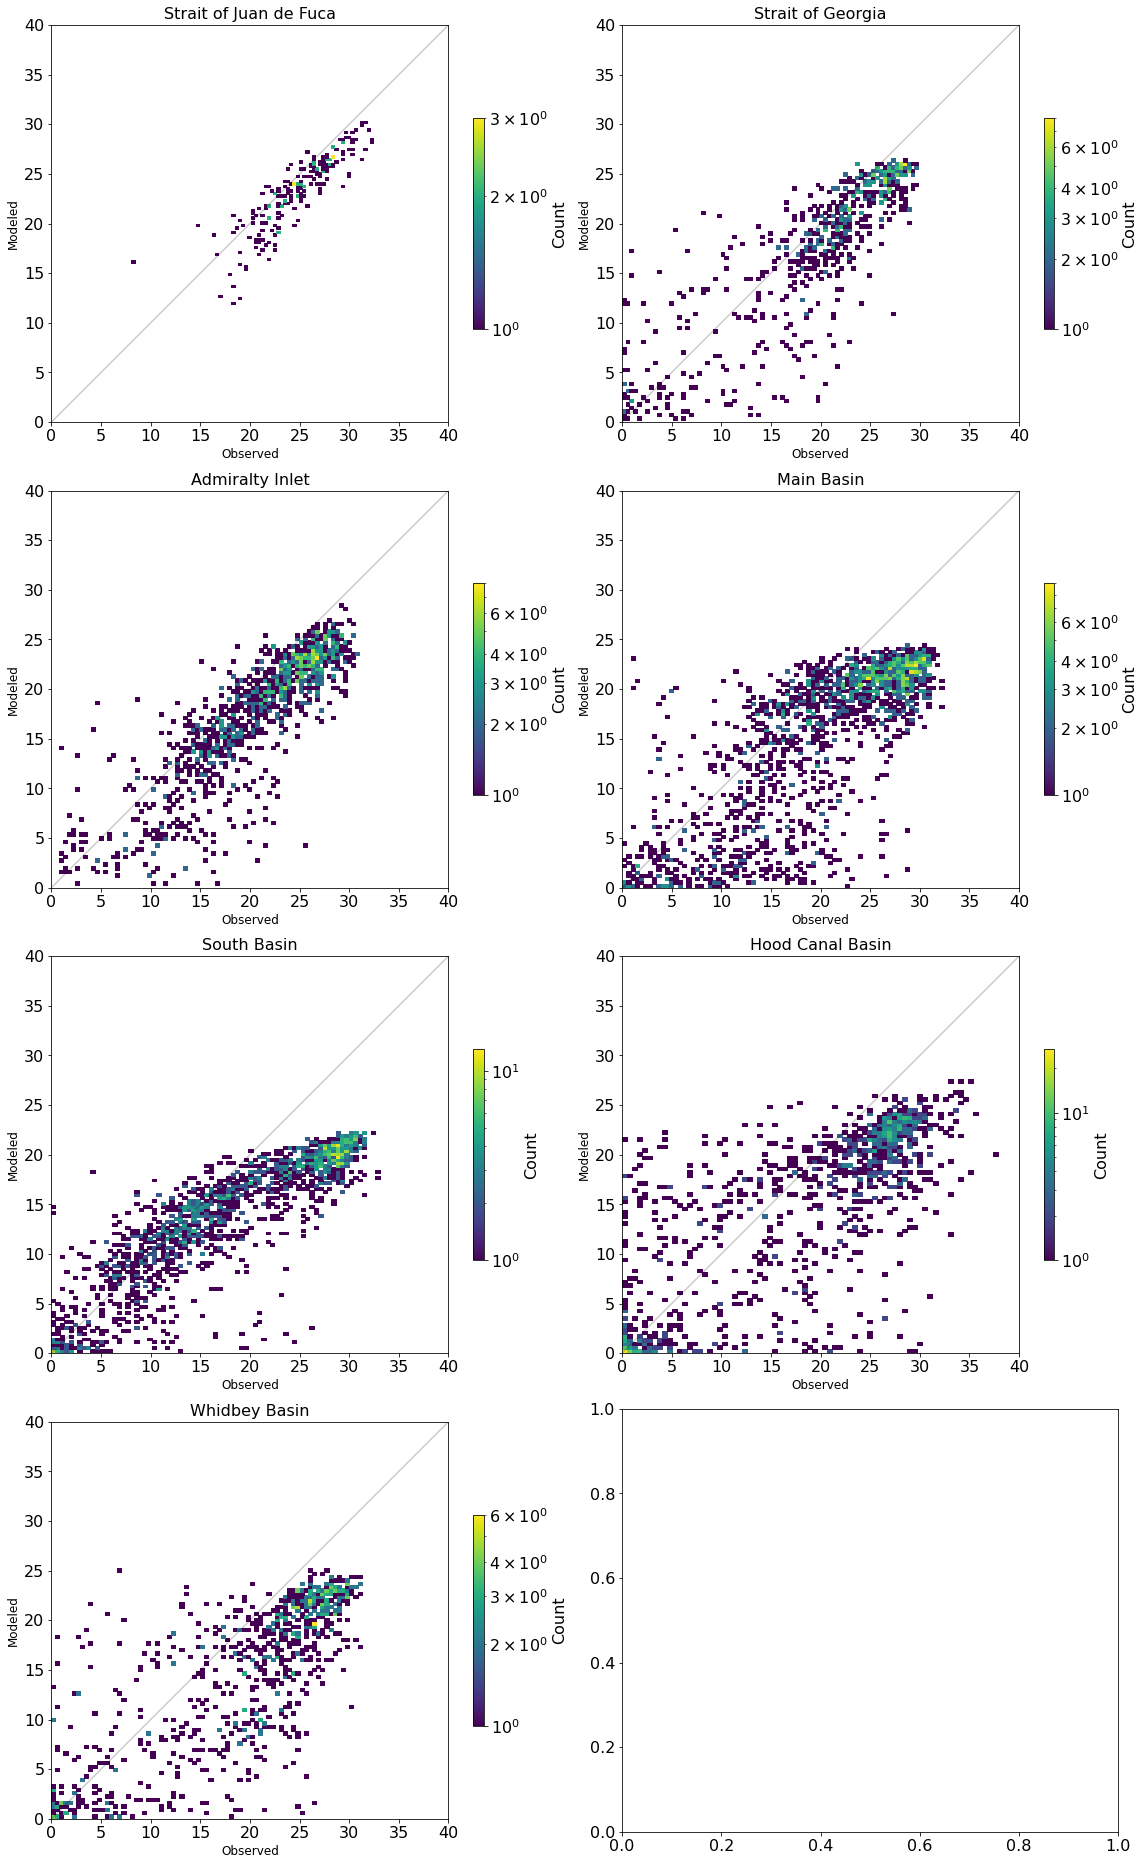

In [16]:
# Should alter to by region 2d histograms.
obsvar='NO23'
modvar='mod_nitrate'
regions=['Strait of Juan de Fuca','Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']
lims=(0,40)
ket.byRegion_hist2d(datreg,regions,obsvar,modvar,lims)

# Dissolved Silica

### Table containing evaluation statistics for relevant subsets

In [17]:
# Defining Variables needed for silica determination 
obsvar='Si'
modvar='mod_silicon'
seasons=[JFM,Apr,MJJA,SOND]

In [18]:
statsDict['dSi']=OrderedDict()
for isub in statsubs:
    statsDict['dSi'][isub]=dict()
    var=statsDict['dSi'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict['dSi'],level='Subset',suborder=list(statsubs.keys()))
tbl

### Model vs Observed comparisons by depth and region

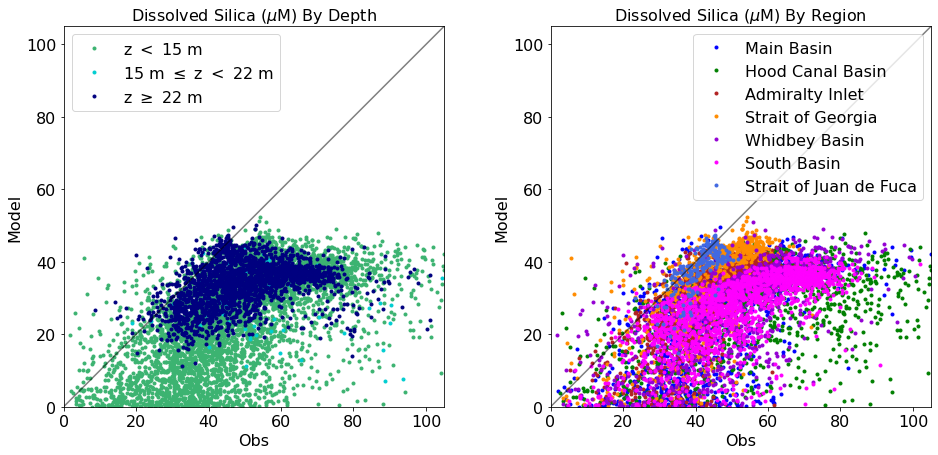

In [19]:
mv=(0,105)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data,obsvar,modvar,mv)
ax[0].set_title('Dissolved Silica ($\mu$M) By Depth')

ps,l=ket.byRegion(ax[1],data,datreg,obsvar,modvar,mv)
ax[1].set_title('Dissolved Silica ($\mu$M) By Region');

## 2D histogram of modeled vs observed data

Text(0.5, 1.0, 'Si ($\\mu$M)')

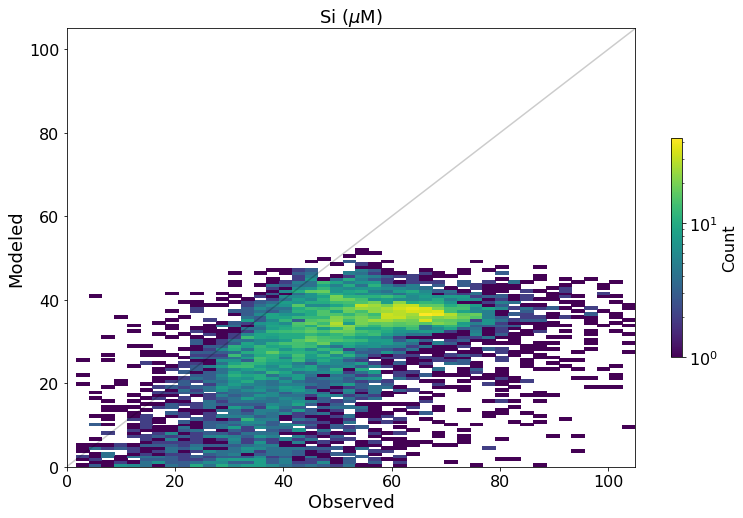

In [20]:
fig, ax = plt.subplots(1,1,figsize= (11,7))
ps = ket.hist2d(ax,fig,data,obsvar,modvar,mv,fontsize=18)
ax.set_title('Si ($\mu$M)',fontsize=18)

### Model vs Observed comparisons for individual seasons

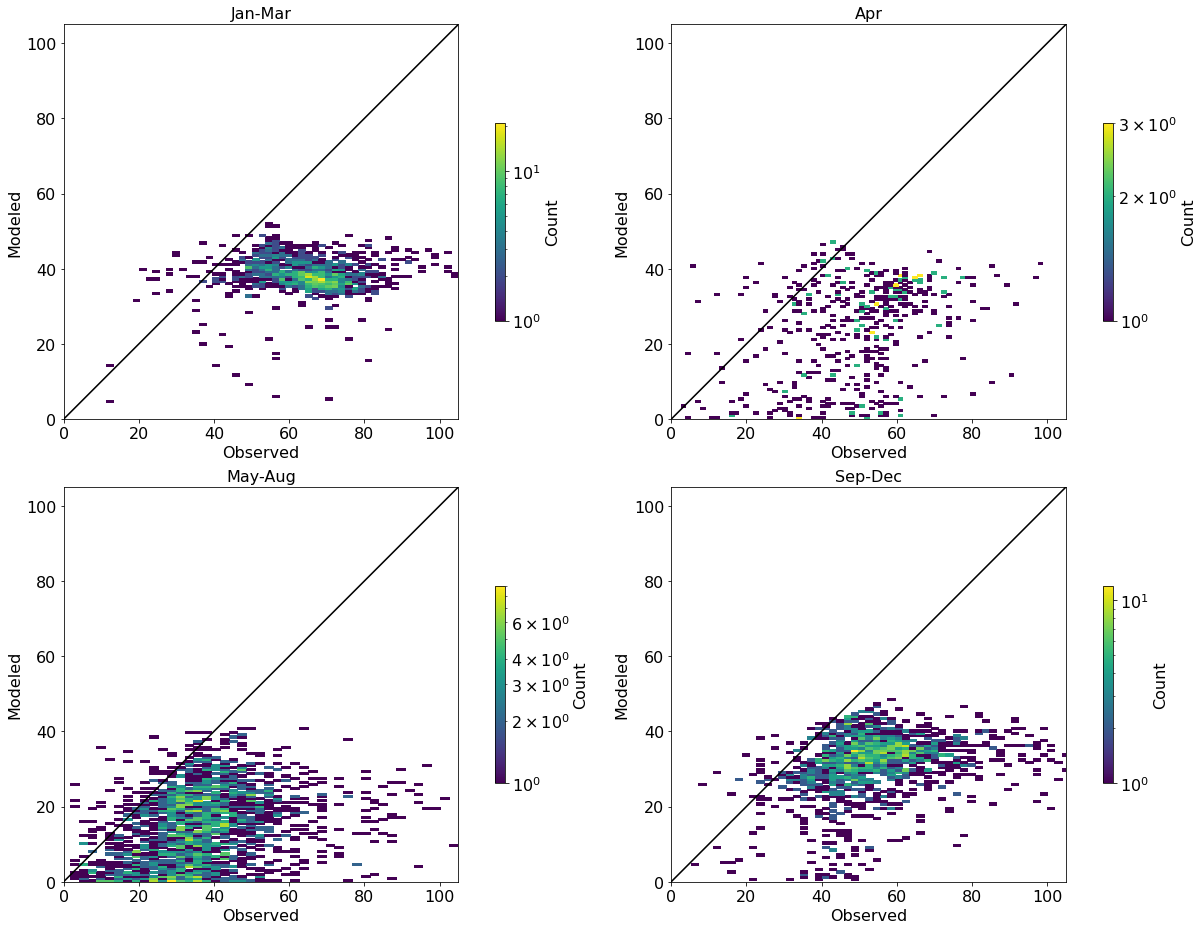

In [21]:
fig, ax = plt.subplots(2,2,figsize = (19,13))
ket.bySeason_hist2d(ax,fig,seasons,obsvar,modvar,mv)
for i in range(2):
    for j in range(2):
        ax[i][j].set_ylabel('Modeled',fontsize=16)
        ax[i][j].set_xlabel('Observed',fontsize=16)   

### Model vs Observed comparisons for individual regions

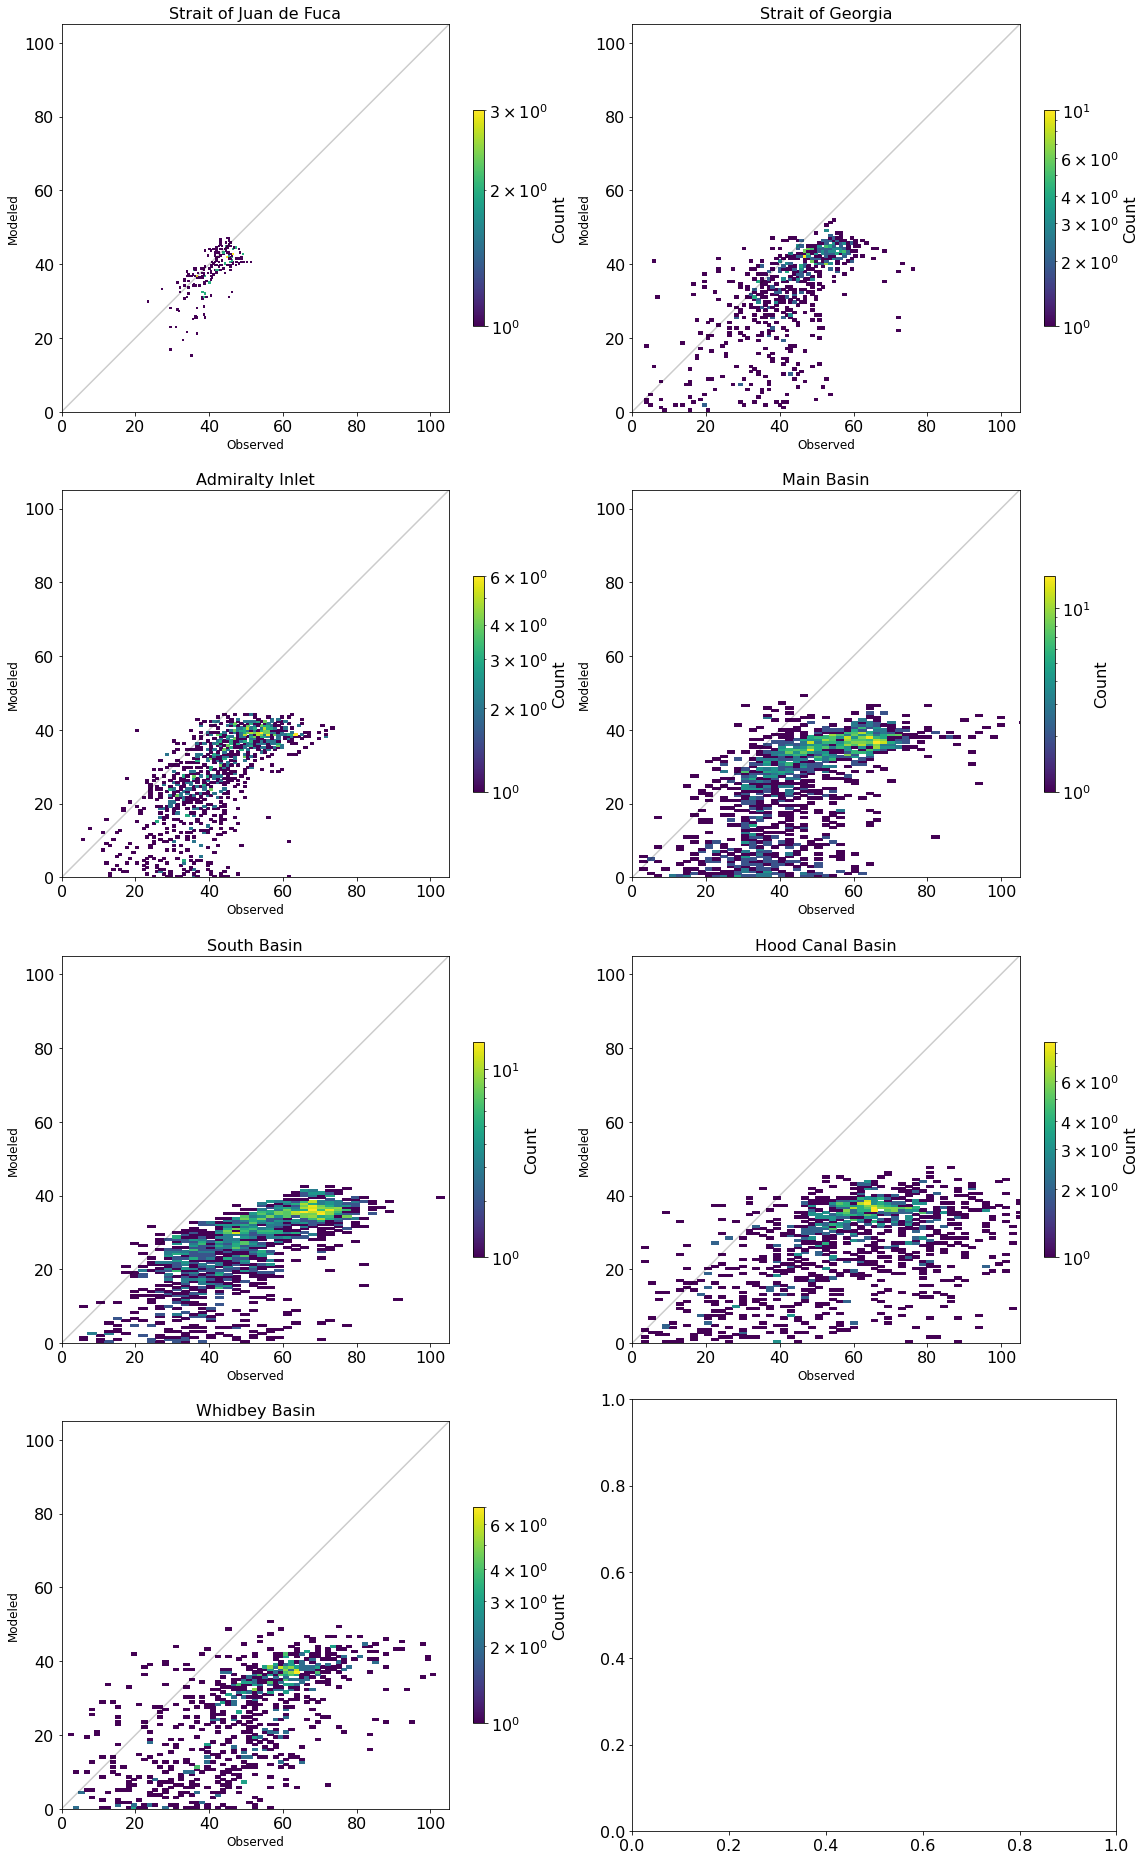

In [22]:
# Should alter to by region 2d histograms.
regions=['Strait of Juan de Fuca','Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']
lims=(0,105)
ket.byRegion_hist2d(datreg,regions,obsvar,modvar,lims)

# dSi:NO3 Ratios

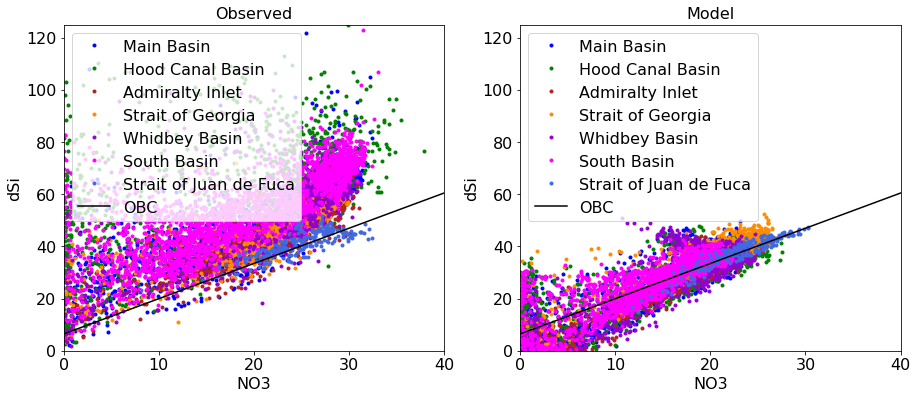

In [23]:
fig,ax=plt.subplots(1,2,figsize=(15,6))
for ind,iregion in enumerate(data.Basin.unique()):
    p1=ax[0].plot(datreg[iregion]['NO23'],datreg[iregion]['Si'],'.',
                  color=colors[ind],label=iregion)
ax[0].plot(np.arange(0,41),1.35*np.arange(0,41)+6.46,'k-',label='OBC')  
ax[0].set_title('Observed')
ax[0].set_xlabel('NO3')
ax[0].set_ylabel('dSi')
ax[0].set_xlim(0,40)
ax[0].set_ylim(0,125)
ax[0].legend()

for ind,iregion in enumerate(data.Basin.unique()):
    p=ax[1].plot(datreg[iregion]['mod_nitrate'],datreg[iregion]['mod_silicon'],'.',  
                  color=colors[ind],label=iregion)
ax[1].plot(np.arange(0,41),1.35*np.arange(0,41)+6.46,'k-',label='OBC')
ax[1].set_title('Model')
ax[1].set_xlabel('NO3')
ax[1].set_ylabel('dSi')
ax[1].set_xlim(0,40)
ax[1].set_ylim(0,125)
ax[1].legend()
#ax[0].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')
#ax[1].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')

# NH4

### Table containing evaluation statistics for relevant subsets

In [24]:
# Defining Variables for determining Ammonium
obsvar='Amm'
modvar='mod_ammonium'
seasons=[JFM,Apr,MJJA,SOND]

In [25]:
statsDict['NH4']=OrderedDict()
for isub in statsubs:
    statsDict['NH4'][isub]=dict()
    var=statsDict['NH4'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict['NH4'],level='Subset',suborder=list(statsubs.keys()))
tbl

### Model vs Observed comparisons by depth and region

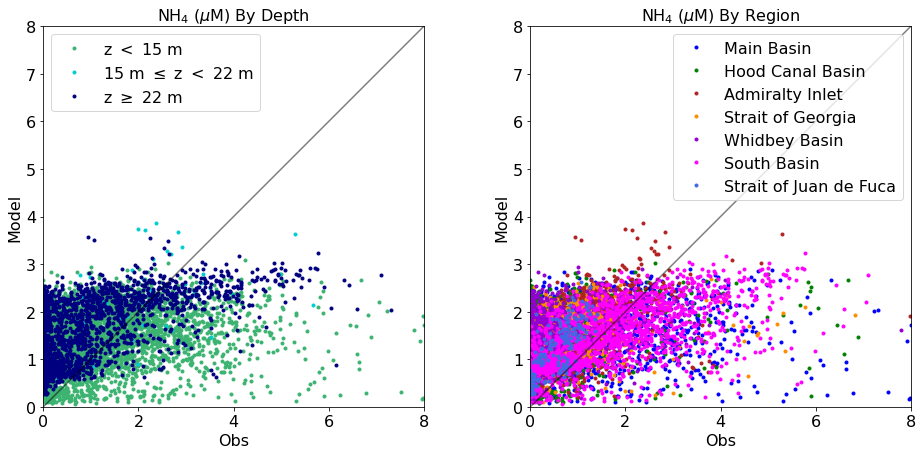

In [26]:
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data,obsvar,modvar,(0,8))
ax[0].set_title('NH$_4$ ($\mu$M) By Depth')

ps,l=ket.byRegion(ax[1],data,datreg,obsvar,modvar,(0,8))
ax[1].set_title('NH$_4$ ($\mu$M) By Region');

## 2D histogram of modeled vs observed data

Text(0.5, 1.0, 'Si ($\\mu$M)')

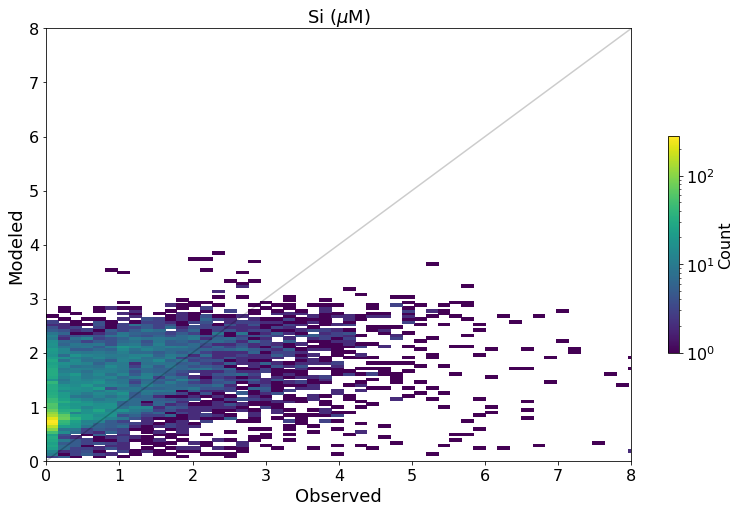

In [27]:
mv=(0,8)
fig, ax = plt.subplots(1,1,figsize= (11,7))
ps = ket.hist2d(ax,fig,data,obsvar,modvar,mv,fontsize=18)
ax.set_title('Si ($\mu$M)',fontsize=18)

### Model vs Observed comparisons for individual seasons

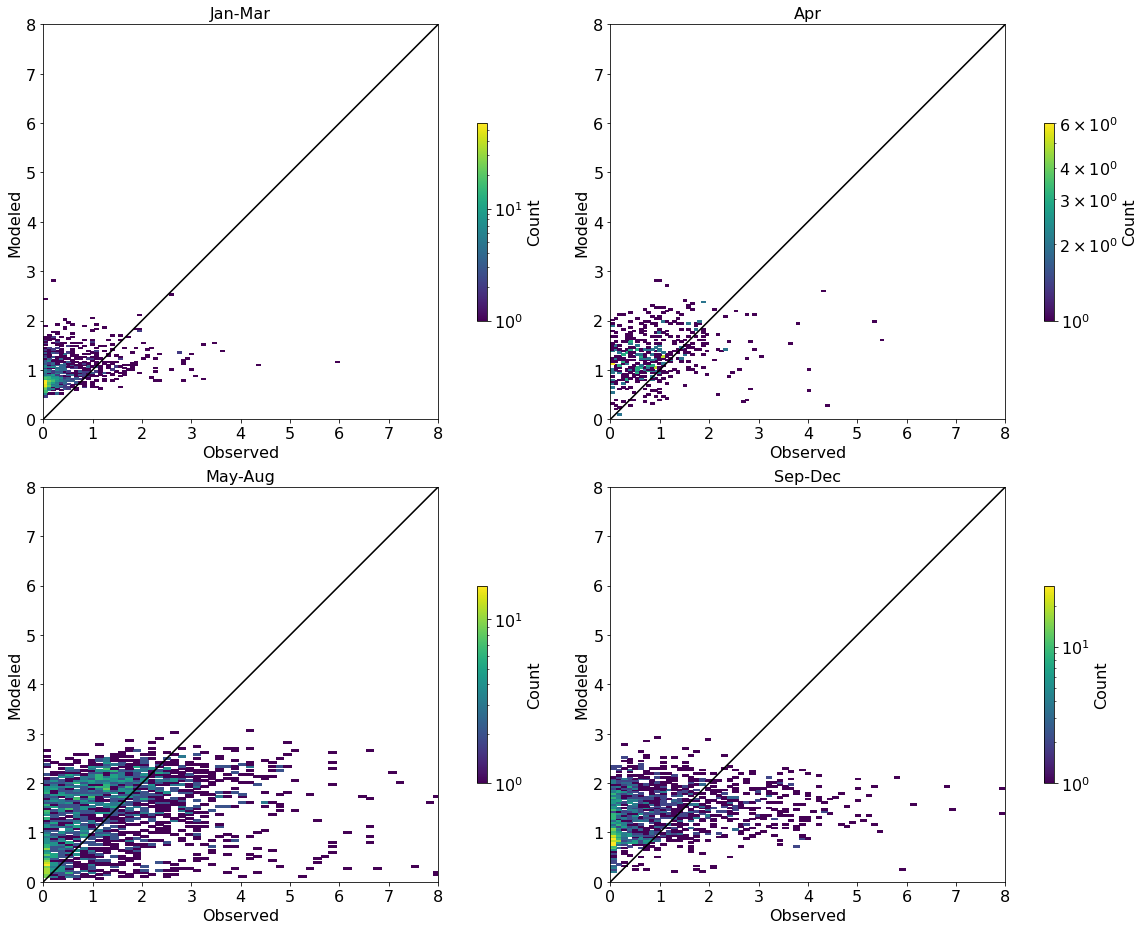

In [28]:
fig, ax = plt.subplots(2,2,figsize = (19,13))
ket.bySeason_hist2d(ax,fig,seasons,obsvar,modvar,mv)
for i in range(2):
    for j in range(2):
        ax[i][j].set_ylabel('Modeled',fontsize=16)
        ax[i][j].set_xlabel('Observed',fontsize=16)   

### Model vs Observed comparisons for individual regions and stations

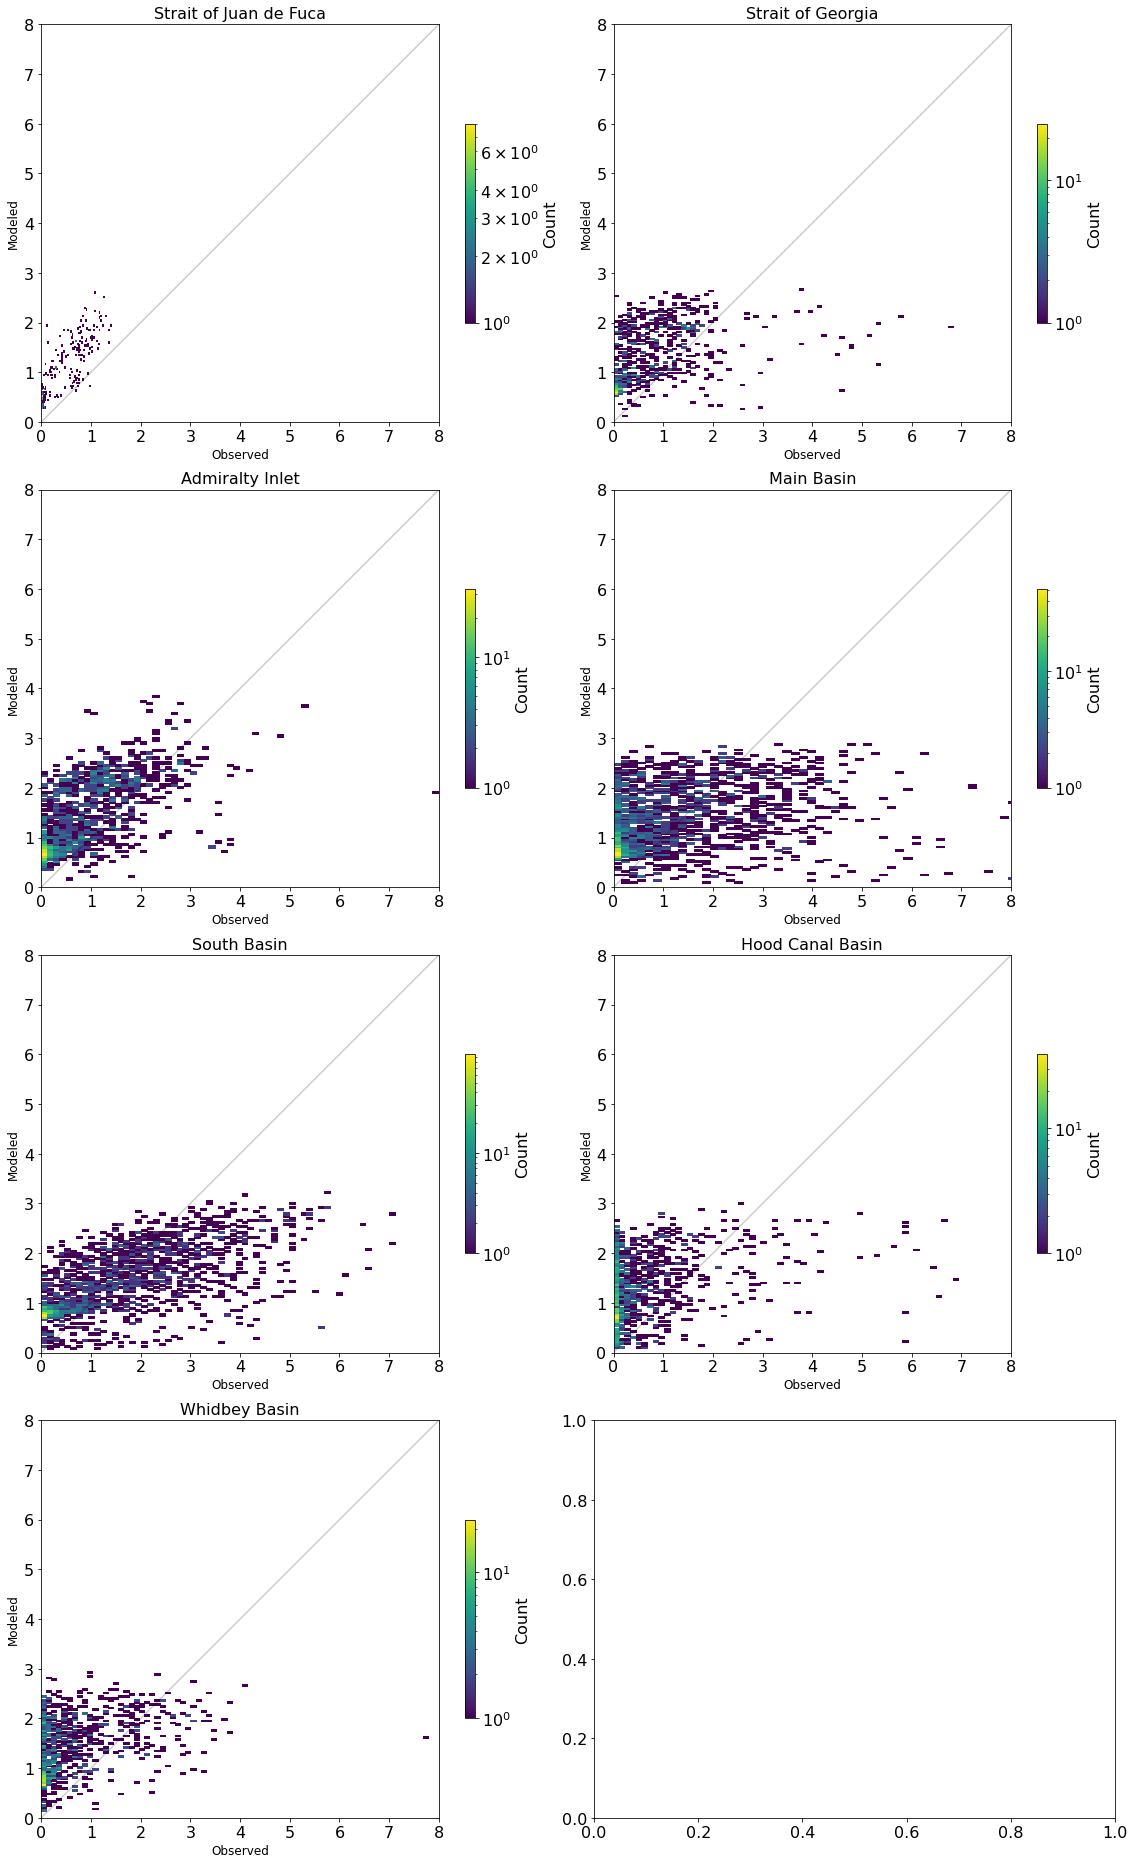

In [29]:
# Should alter to by region 2d histograms.
regions=['Strait of Juan de Fuca','Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']
lims=(0,8)
ket.byRegion_hist2d(datreg,regions,obsvar,modvar,lims)

## Error vs temperature

In [30]:
def hist2d(ax,fig,df,obsvar,modvar,lims,fontsize=12):
    ax.plot(lims,lims,'k-',alpha=.2)
    ii=(~np.isnan(df[obsvar]))&(~np.isnan(df[modvar]))
    counts, xedges, yedges, ps=ax.hist2d(df.loc[ii,[obsvar]].values.flatten(),
                                      df.loc[ii,[modvar]].values.flatten(),bins=25*3,norm=LogNorm())
    cb=fig.colorbar(ps,ax=ax,label='Count',shrink=0.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_ylabel('Modeled',fontsize=fontsize)
    ax.set_xlabel('Observed',fontsize=fontsize)
    plt.tight_layout()
    return ps  

def hist2d_err(ax,fig,df,envvar,modvar,obsvar):
    ii=(~np.isnan(df[envvar]))&(~np.isnan(df[modvar]))&(~np.isnan(df[obsvar]))
    counts, xedges, yedges, ps=ax.hist2d(df.loc[ii,[envvar]].values.flatten(),
                                      df.loc[ii,[modvar]].values.flatten()-df.loc[ii,[obsvar]].values.flatten()
                                         ,bins=25*3,norm=LogNorm())
    cb=fig.colorbar(ps,ax=ax,shrink=0.8)
    ax.set_ylabel('Modeled')
    ax.set_xlabel('Observed')
    plt.tight_layout()
    return ps
    

Text(606.6090526190476, 0.5, 'NO2+NO3 Error ($\\mu$M)')

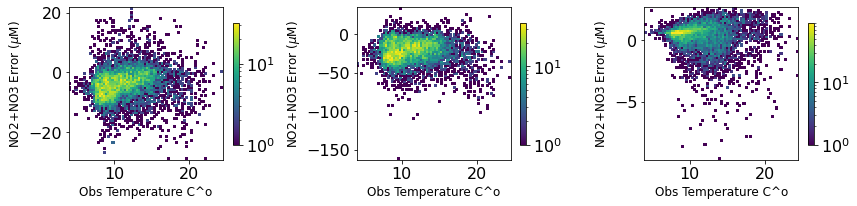

In [31]:
fig,ax=plt.subplots(1,3,figsize=(12,3))
fig.subplots_adjust(wspace=.6)
hist2d_err(ax[0],fig,data,'CT','mod_nitrate','NO23')
ax[0].set_xlabel('Obs Temperature C^o',fontsize=12)
ax[0].set_ylabel('NO2+NO3 Error ($\mu$M)',fontsize=12)

hist2d_err(ax[1],fig,data,'CT','mod_silicon','Si')
ax[1].set_xlabel('Obs Temperature C^o',fontsize=12)
ax[1].set_ylabel('NO2+NO3 Error ($\mu$M)',fontsize=12)

hist2d_err(ax[2],fig,data,'CT','mod_ammonium','Amm')
ax[2].set_xlabel('Obs Temperature C^o',fontsize=12)
ax[2].set_ylabel('NO2+NO3 Error ($\mu$M)',fontsize=12)

## Error vs salinity

Text(606.6090526190476, 0.5, 'NO2+NO3 Error ($\\mu$M)')

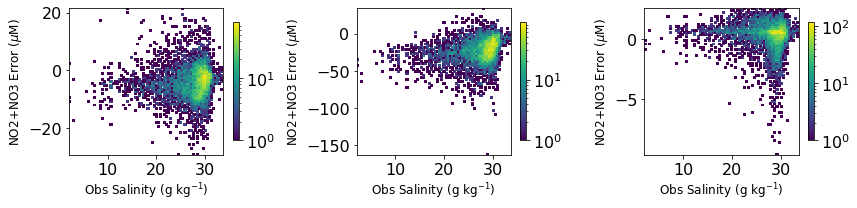

In [32]:
fig,ax=plt.subplots(1,3,figsize=(12,3))
fig.subplots_adjust(wspace=.6)
hist2d_err(ax[0],fig,data,'SA','mod_nitrate','NO23')
ax[0].set_xlabel('Obs Salinity (g kg$^{-1}$)',fontsize=12)
ax[0].set_ylabel('NO2+NO3 Error ($\mu$M)',fontsize=12)

hist2d_err(ax[1],fig,data,'SA','mod_silicon','Si')
ax[1].set_xlabel('Obs Salinity (g kg$^{-1}$)',fontsize=12)
ax[1].set_ylabel('NO2+NO3 Error ($\mu$M)',fontsize=12)

hist2d_err(ax[2],fig,data,'SA','mod_ammonium','Amm')
ax[2].set_xlabel('Obs Salinity (g kg$^{-1}$)',fontsize=12)
ax[2].set_ylabel('NO2+NO3 Error ($\mu$M)',fontsize=12)

## Error vs salinity error

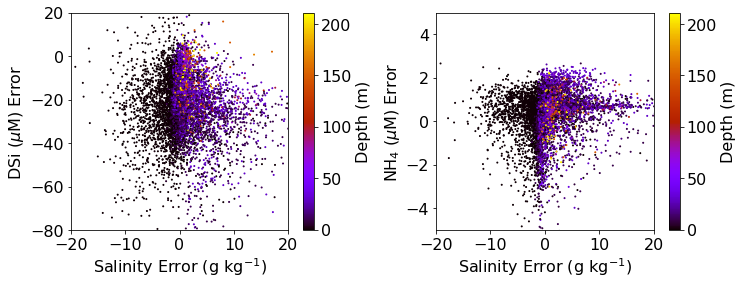

In [33]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].set_xlabel('Salinity Error (g kg$^{-1}$)')
ax[0].set_ylabel('DSi ($\mu$M) Error')
m,cb=ket.ErrErr(data,fig,ax[0],'SA','mod_vosaline','Si','mod_silicon',(-20,20),(-80,20))
ax[1].set_xlabel('Salinity Error (g kg$^{-1}$)')
ax[1].set_ylabel('NH$_4$ ($\mu$M) Error')
m,cb=ket.ErrErr(data,fig,ax[1],'SA','mod_vosaline','Amm','mod_ammonium',(-20,20),(-5,5))

## Error vs lat

Text(596.4840526190476, 0.5, 'NO2+NO3 Error ($\\mu$M)')

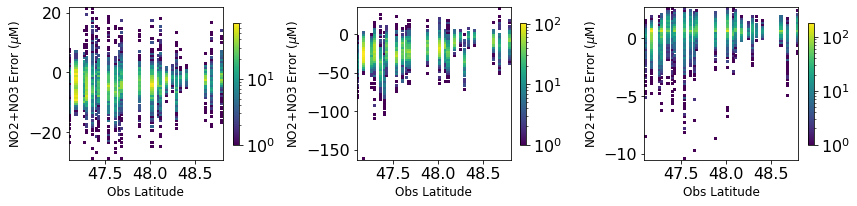

In [34]:
fig,ax=plt.subplots(1,3,figsize=(12,3))
fig.subplots_adjust(wspace=.6)
hist2d_err(ax[0],fig,data,'Lat','mod_nitrate','NO23')
ax[0].set_xlabel('Obs Latitude',fontsize=12)
ax[0].set_ylabel('NO2+NO3 Error ($\mu$M)',fontsize=12)

hist2d_err(ax[1],fig,data,'Lat','mod_silicon','Si')
ax[1].set_xlabel('Obs Latitude',fontsize=12)
ax[1].set_ylabel('NO2+NO3 Error ($\mu$M)',fontsize=12)

hist2d_err(ax[2],fig,data,'Lat','mod_ammonium','Amm')
ax[2].set_xlabel('Obs Latitude',fontsize=12)
ax[2].set_ylabel('NO2+NO3 Error ($\mu$M)',fontsize=12)

In [35]:
tbl,tdf=et.displayStats(statsDict,level='Variable',suborder=list(statsubs.keys()))
tbl